In [1]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os


In [ ]:
folder_path= "dataset/Rice_Leaf"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    seed=123,
    shuffle=True,
    image_size=(256, 256),
    batch_size=32)

Found 11790 files belonging to 9 classes.


In [3]:
class_names=dataset.class_names
class_names

['Bacterial Leaf Blight',
 'Brown Spot',
 'Healthy Rice Leaf',
 'Leaf Blast',
 'Leaf scald',
 'Narrow Brown Leaf Spot',
 'Neck_Blast',
 'Rice Hispa',
 'Sheath Blight']

In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = sum(1 for _ in ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [5]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

resize_and_rescale = models.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1/255) 
])

input_shape = (256, 256, 3)
n_classes = 9

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax'),
])

optimizer = optimizers.Adam(learning_rate=0.0005) 

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.00005)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [7]:

history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[reduce_lr,early_stopping])

Epoch 1/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 96s 158ms/step - accuracy: 0.2505 - loss: 1.9856 - val_accuracy: 0.5677 - val_loss: 1.3136 - learning_rate: 5.0000e-04
Epoch 2/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 74s 142ms/step - accuracy: 0.4944 - loss: 1.3968 - val_accuracy: 0.6493 - val_loss: 1.0518 - learning_rate: 5.0000e-04
Epoch 3/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 74s 142ms/step - accuracy: 0.6007 - loss: 1.1366 - val_accuracy: 0.7552 - val_loss: 0.7723 - learning_rate: 5.0000e-04
Epoch 4/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 73s 140ms/step - accuracy: 0.6596 - loss: 0.9782 - val_accuracy: 0.8168 - val_loss: 0.5811 - learning_rate: 5.0000e-04
Epoch 5/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 73s 141ms/step - accuracy: 0.7179 - loss: 0.8198 - val_accuracy: 0.8333 - val_loss: 0.5030 - learning_rate: 5.0000e-04
Epoch 6/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 74s 141ms/step - accuracy: 0.7611 - loss: 0.6683 - val_accuracy: 0.8611 - val_loss: 0.4222 - learning_rate: 5.0000e-04
Epoch 7/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 73s 14

In [8]:
from PIL import Image
import numpy as np
image_path = "/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG/Leaf scald/IMG_20231006_163826.jpg"
image = Image.open(image_path)
img_array = tf.keras.preprocessing.image.img_to_array(image)
img_array = tf.expand_dims(img_array, 0)

predictions=model.predict(img_array)

print(predictions)

predicted_class = class_names[np.argmax(predictions)]
print (predicted_class)
print (np.max(predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
[[1.3135669e-07 3.7637760e-14 3.1919817e-20 3.4077048e-09 9.9999988e-01
  1.2703733e-08 5.5835393e-13 5.3494556e-14 1.7560342e-09]]
Leaf scald
0.9999999


In [ ]:
model.save("RiceDiseaseModel.h5")

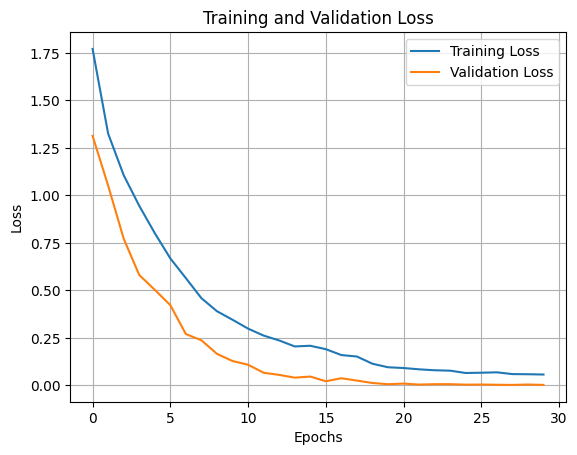

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

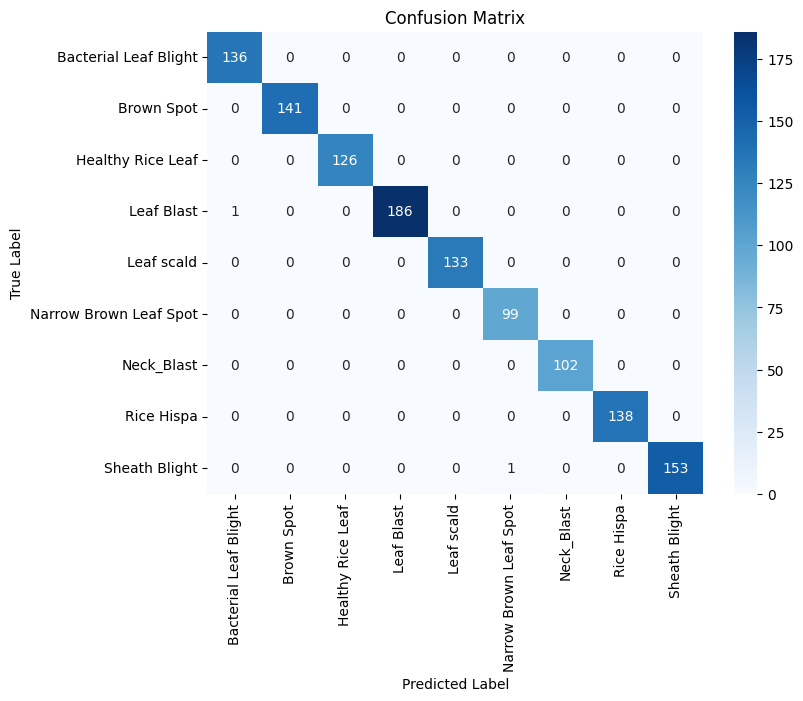

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images) 
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1)) 

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
